In [ ]:
!pip install furo
#!pip install graphviz
!pip install matplotlib
!pip install numpy
!pip install pandas
!pip install prettytable
!pip install scikit-learn
!pip install scipy
!pip install setuptools
!pip install sphinx-gallery
!pip install sphinxemoji
!pip install termcolor
#!winget install -e --id Graphviz.Graphviz

!pip install trustee --user

In [26]:
import numpy as np
import csv
import pandas as pd
import os
import shutil
import joblib
import pydotplus
import graphviz

from sklearn import tree

from trustee import ClassificationTrustee
from trustee.utils.tree import get_dt_info, top_k_prune

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier

In [19]:
# MAXP POOLING

def max_pooling(input_array, pool_size, stride):
    output_shape = (
        (input_array.shape[0] - pool_size) // stride + 1,
        (input_array.shape[1] - pool_size) // stride + 1
    )
    pooled_array = np.zeros(output_shape)
    
    for i in range(0, output_shape[0]):
        for j in range(0, output_shape[1]):
            pooled_array[i, j] = np.max(
                input_array[
                    i * stride : i * stride + pool_size,
                    j * stride : j * stride + pool_size
                ]
            )
    
    return pooled_array

In [51]:
def MyFeature(feature_index):
    
    if feature_index==0:
        return 0

    pooled_array_size = 100  # cnn 1500  
    
    # חישוב ערכי ה-x וה-y
    y = feature_index // pooled_array_size
    y = y*15 # cnn להוריד
    x = feature_index-1
    x = x % pooled_array_size
    x = x*15 # cnn להוריד
    
    return f'{x}-{x+15},{y}-{y+15}'  # x,y להחליף ל

In [53]:
# LOAD DATASET

labels = ['Youtube', 'GoogleDoc', 'GoogleDrive']

features_path = "features"

df = pd.DataFrame()

for label in labels:
    folder_path = os.path.join(features_path, label)
    for filename in os.listdir(folder_path):
        if filename.endswith('0.npy'):
            file_path = os.path.join(folder_path, filename)
            # Load the .npy file and sum
            temp = np.load(file_path)
            trans = np.transpose(temp)
            
            pooled = max_pooling(trans, 15, 15)

            # Apply Singular Value Decomposition (SVD) for dimensionality reduction
            new_row = pd.DataFrame([np.append(label, pooled.flatten())] , columns=[f'feature_{MyFeature(i)}' for i in range(10001)])
            # Append the new row to the DataFrame
            df = pd.concat([df, new_row], ignore_index=True)

In [54]:
df

,feature_0,"feature_0-15,0-15","feature_15-30,0-15","feature_30-45,0-15","feature_45-60,0-15","feature_60-75,0-15","feature_75-90,0-15","feature_90-105,0-15","feature_105-120,0-15","feature_120-135,0-15",...,"feature_1350-1365,1485-1500","feature_1365-1380,1485-1500","feature_1380-1395,1485-1500","feature_1395-1410,1485-1500","feature_1410-1425,1485-1500","feature_1425-1440,1485-1500","feature_1440-1455,1485-1500","feature_1455-1470,1485-1500","feature_1470-1485,1485-1500","feature_1485-1500,1500-1515"
0,Youtube,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Youtube,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Youtube,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Youtube,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Youtube,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3384,GoogleDrive,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3385,GoogleDrive,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3386,GoogleDrive,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3387,GoogleDrive,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [55]:
df.to_csv("df_x,y_pooling.csv", index=False)

In [56]:
# Load the df
df = pd.read_csv("df_x,y_pooling.csv")

y = df['feature_0']
X = df.drop(columns = ['feature_0'], inplace = False)

# Split the data into 70% training and 30% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define the Random Forest classifier
classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier on the training set
classifier.fit(X_train, y_train)

# Evaluate the classifier on the test set
test_score = classifier.score(X_test, y_test)
print("Test set accuracy:", test_score)

Test set accuracy: 0.9901671583087512


In [57]:
y_pred = classifier.predict(X_test)

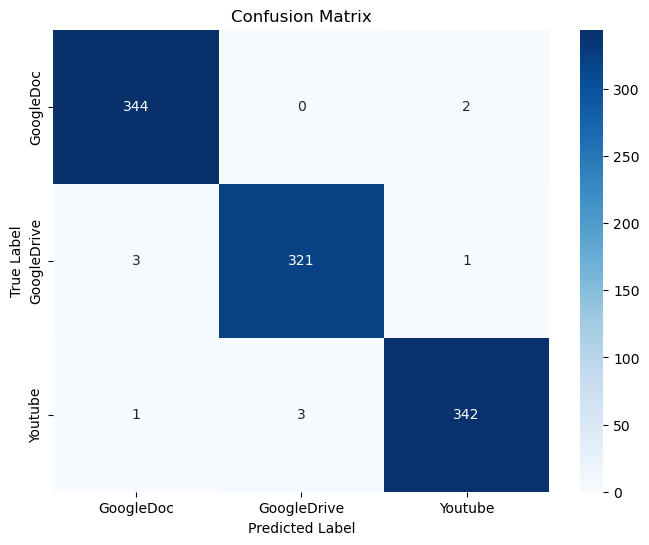

In [58]:
# Generate the confusion matrix
category_labels = ['GoogleDoc', 'GoogleDrive', 'Youtube']
conf_matrix = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=category_labels, yticklabels=category_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [ ]:
# joblib.dump(classifier, 'quic_text_rf_pooling.joblib') # put model here to export

# Trustee

In [59]:
# Load the trained model
#model = joblib.load('quic_text_rf.joblib')
num_iter=50
num_stability_iter=10

trustee = ClassificationTrustee(expert=classifier)
trustee.fit(X_train, y_train, num_iter=num_iter, num_stability_iter=num_stability_iter, samples_size=0.3, verbose=True)
dt, pruned_dt, agreement, reward = trustee.explain()
dt_y_pred = dt.predict(X_test)
pruned_dt_y_pred = pruned_dt.predict(X_test)

all_trees = trustee.get_all_students()

print("Model explanation global fidelity report:")
print(classification_report(y_pred, dt_y_pred))
print("Model explanation score report:")
print(classification_report(y_test, dt_y_pred))

Initializing training dataset using RandomForestClassifier(random_state=42) as expert model
Expert model score: 1.0
Initializing Trustee outer-loop with 10 iterations
########## Outer-loop Iteration 0/10 ##########
Initializing Trustee inner-loop with 10 iterations
########## Inner-loop Iteration 0/50 ##########
Sampling 498 points from training dataset with (1660, 1660) entries
Student model 0-0 trained with depth 6 and 13 leaves:
Student model score: 0.9312484108822782
Student model 0-0 fidelity: 0.9312484108822782
########## Inner-loop Iteration 1/50 ##########
Sampling 498 points from training dataset with (1810, 1810) entries
Student model 0-1 trained with depth 9 and 13 leaves:
Student model score: 0.9461895199847007
Student model 0-1 fidelity: 0.9461895199847007
########## Inner-loop Iteration 2/50 ##########
Sampling 498 points from training dataset with (1960, 1960) entries
Student model 0-2 trained with depth 7 and 12 leaves:
Student model score: 0.9536836253555213
Student mo

Student model 0-31 trained with depth 5 and 13 leaves:
Student model score: 0.9598362101720674
Student model 0-31 fidelity: 0.9598362101720674
########## Inner-loop Iteration 32/50 ##########
Sampling 498 points from training dataset with (6460, 6460) entries
Student model 0-32 trained with depth 7 and 11 leaves:
Student model score: 0.9532369864846783
Student model 0-32 fidelity: 0.9532369864846783
########## Inner-loop Iteration 33/50 ##########
Sampling 498 points from training dataset with (6610, 6610) entries
Student model 0-33 trained with depth 7 and 13 leaves:
Student model score: 0.9514888264888265
Student model 0-33 fidelity: 0.9514888264888265
########## Inner-loop Iteration 34/50 ##########
Sampling 498 points from training dataset with (6760, 6760) entries
Student model 0-34 trained with depth 7 and 12 leaves:
Student model score: 0.9438136319831708
Student model 0-34 fidelity: 0.9438136319831708
########## Inner-loop Iteration 35/50 ##########
Sampling 498 points from tra

Student model 1-12 fidelity: 0.9640698643925746
########## Inner-loop Iteration 13/50 ##########
Sampling 498 points from training dataset with (11110, 11110) entries
Student model 1-13 trained with depth 7 and 16 leaves:
Student model score: 0.9282597564504996
Student model 1-13 fidelity: 0.9282597564504996
########## Inner-loop Iteration 14/50 ##########
Sampling 498 points from training dataset with (11260, 11260) entries
Student model 1-14 trained with depth 8 and 14 leaves:
Student model score: 0.9546620335898073
Student model 1-14 fidelity: 0.9546620335898073
########## Inner-loop Iteration 15/50 ##########
Sampling 498 points from training dataset with (11410, 11410) entries
Student model 1-15 trained with depth 7 and 12 leaves:
Student model score: 0.9652759349353777
Student model 1-15 fidelity: 0.9652759349353777
########## Inner-loop Iteration 16/50 ##########
Sampling 498 points from training dataset with (11560, 11560) entries
Student model 1-16 trained with depth 6 and 17 

Student model 1-44 fidelity: 0.9206770081770083
########## Inner-loop Iteration 45/50 ##########
Sampling 498 points from training dataset with (15910, 15910) entries
Student model 1-45 trained with depth 8 and 14 leaves:
Student model score: 0.9539844580179917
Student model 1-45 fidelity: 0.9539844580179917
########## Inner-loop Iteration 46/50 ##########
Sampling 498 points from training dataset with (16060, 16060) entries
Student model 1-46 trained with depth 7 and 13 leaves:
Student model score: 0.9595496023620046
Student model 1-46 fidelity: 0.9595496023620046
########## Inner-loop Iteration 47/50 ##########
Sampling 498 points from training dataset with (16210, 16210) entries
Student model 1-47 trained with depth 7 and 13 leaves:
Student model score: 0.9666646664666466
Student model 1-47 fidelity: 0.9666646664666466
########## Inner-loop Iteration 48/50 ##########
Sampling 498 points from training dataset with (16360, 16360) entries
Student model 1-48 trained with depth 6 and 14 

Student model 2-26 fidelity: 0.967376644630999
########## Inner-loop Iteration 27/50 ##########
Sampling 498 points from training dataset with (20710, 20710) entries
Student model 2-27 trained with depth 6 and 10 leaves:
Student model score: 0.9852032520325203
Student model 2-27 fidelity: 0.9852032520325203
########## Inner-loop Iteration 28/50 ##########
Sampling 498 points from training dataset with (20860, 20860) entries
Student model 2-28 trained with depth 5 and 13 leaves:
Student model score: 0.9523811435806424
Student model 2-28 fidelity: 0.9523811435806424
########## Inner-loop Iteration 29/50 ##########
Sampling 498 points from training dataset with (21010, 21010) entries
Student model 2-29 trained with depth 7 and 12 leaves:
Student model score: 0.9521506501866323
Student model 2-29 fidelity: 0.9521506501866323
########## Inner-loop Iteration 30/50 ##########
Sampling 498 points from training dataset with (21160, 21160) entries
Student model 2-30 trained with depth 5 and 10 l

Student model 3-8 trained with depth 7 and 14 leaves:
Student model score: 0.9538777371346386
Student model 3-8 fidelity: 0.9538777371346386
########## Inner-loop Iteration 9/50 ##########
Sampling 498 points from training dataset with (25510, 25510) entries
Student model 3-9 trained with depth 7 and 15 leaves:
Student model score: 0.9447437336326224
Student model 3-9 fidelity: 0.9447437336326224
########## Inner-loop Iteration 10/50 ##########
Sampling 498 points from training dataset with (25660, 25660) entries
Student model 3-10 trained with depth 5 and 9 leaves:
Student model score: 0.979508146577214
Student model 3-10 fidelity: 0.979508146577214
########## Inner-loop Iteration 11/50 ##########
Sampling 498 points from training dataset with (25810, 25810) entries
Student model 3-11 trained with depth 5 and 10 leaves:
Student model score: 0.9478776792833358
Student model 3-11 fidelity: 0.9478776792833358
########## Inner-loop Iteration 12/50 ##########
Sampling 498 points from train

Student model 3-39 fidelity: 0.9676986695433297
########## Inner-loop Iteration 40/50 ##########
Sampling 498 points from training dataset with (30160, 30160) entries
Student model 3-40 trained with depth 6 and 14 leaves:
Student model score: 0.927868067705647
Student model 3-40 fidelity: 0.927868067705647
########## Inner-loop Iteration 41/50 ##########
Sampling 498 points from training dataset with (30310, 30310) entries
Student model 3-41 trained with depth 6 and 10 leaves:
Student model score: 0.9594047986819071
Student model 3-41 fidelity: 0.9594047986819071
########## Inner-loop Iteration 42/50 ##########
Sampling 498 points from training dataset with (30460, 30460) entries
Student model 3-42 trained with depth 6 and 14 leaves:
Student model score: 0.9245009061974311
Student model 3-42 fidelity: 0.9245009061974311
########## Inner-loop Iteration 43/50 ##########
Sampling 498 points from training dataset with (30610, 30610) entries
Student model 3-43 trained with depth 6 and 11 le

Student model 4-21 trained with depth 7 and 15 leaves:
Student model score: 0.9184083105316808
Student model 4-21 fidelity: 0.9184083105316808
########## Inner-loop Iteration 22/50 ##########
Sampling 498 points from training dataset with (34960, 34960) entries
Student model 4-22 trained with depth 5 and 11 leaves:
Student model score: 0.9754655960744953
Student model 4-22 fidelity: 0.9754655960744953
########## Inner-loop Iteration 23/50 ##########
Sampling 498 points from training dataset with (35110, 35110) entries
Student model 4-23 trained with depth 5 and 13 leaves:
Student model score: 0.9719739971460282
Student model 4-23 fidelity: 0.9719739971460282
########## Inner-loop Iteration 24/50 ##########
Sampling 498 points from training dataset with (35260, 35260) entries
Student model 4-24 trained with depth 6 and 13 leaves:
Student model score: 0.9333764224770102
Student model 4-24 fidelity: 0.9333764224770102
########## Inner-loop Iteration 25/50 ##########
Sampling 498 points fr

Student model 5-2 trained with depth 5 and 16 leaves:
Student model score: 0.9321175950486295
Student model 5-2 fidelity: 0.9321175950486295
########## Inner-loop Iteration 3/50 ##########
Sampling 498 points from training dataset with (39610, 39610) entries
Student model 5-3 trained with depth 5 and 14 leaves:
Student model score: 0.945765889456274
Student model 5-3 fidelity: 0.945765889456274
########## Inner-loop Iteration 4/50 ##########
Sampling 498 points from training dataset with (39760, 39760) entries
Student model 5-4 trained with depth 5 and 11 leaves:
Student model score: 0.9647522456248186
Student model 5-4 fidelity: 0.9647522456248186
########## Inner-loop Iteration 5/50 ##########
Sampling 498 points from training dataset with (39910, 39910) entries
Student model 5-5 trained with depth 5 and 13 leaves:
Student model score: 0.9225396458220887
Student model 5-5 fidelity: 0.9225396458220887
########## Inner-loop Iteration 6/50 ##########
Sampling 498 points from training da

Student model 5-34 trained with depth 6 and 12 leaves:
Student model score: 0.9659660645867544
Student model 5-34 fidelity: 0.9659660645867544
########## Inner-loop Iteration 35/50 ##########
Sampling 498 points from training dataset with (44410, 44410) entries
Student model 5-35 trained with depth 8 and 13 leaves:
Student model score: 0.9729607904050095
Student model 5-35 fidelity: 0.9729607904050095
########## Inner-loop Iteration 36/50 ##########
Sampling 498 points from training dataset with (44560, 44560) entries
Student model 5-36 trained with depth 5 and 14 leaves:
Student model score: 0.9533290344485792
Student model 5-36 fidelity: 0.9533290344485792
########## Inner-loop Iteration 37/50 ##########
Sampling 498 points from training dataset with (44710, 44710) entries
Student model 5-37 trained with depth 6 and 13 leaves:
Student model score: 0.9600065782035337
Student model 5-37 fidelity: 0.9600065782035337
########## Inner-loop Iteration 38/50 ##########
Sampling 498 points fr

Student model 6-15 fidelity: 0.9574345825606048
########## Inner-loop Iteration 16/50 ##########
Sampling 498 points from training dataset with (49060, 49060) entries
Student model 6-16 trained with depth 6 and 11 leaves:
Student model score: 0.9610253663761624
Student model 6-16 fidelity: 0.9610253663761624
########## Inner-loop Iteration 17/50 ##########
Sampling 498 points from training dataset with (49210, 49210) entries
Student model 6-17 trained with depth 5 and 10 leaves:
Student model score: 0.9388757502835173
Student model 6-17 fidelity: 0.9388757502835173
########## Inner-loop Iteration 18/50 ##########
Sampling 498 points from training dataset with (49360, 49360) entries
Student model 6-18 trained with depth 6 and 12 leaves:
Student model score: 0.9532831859335493
Student model 6-18 fidelity: 0.9532831859335493
########## Inner-loop Iteration 19/50 ##########
Sampling 498 points from training dataset with (49510, 49510) entries
Student model 6-19 trained with depth 6 and 12 

Student model 6-47 trained with depth 5 and 9 leaves:
Student model score: 0.9607493582168617
Student model 6-47 fidelity: 0.9607493582168617
########## Inner-loop Iteration 48/50 ##########
Sampling 498 points from training dataset with (53860, 53860) entries
Student model 6-48 trained with depth 5 and 12 leaves:
Student model score: 0.9877169258508
Student model 6-48 fidelity: 0.9877169258508
########## Inner-loop Iteration 49/50 ##########
Sampling 498 points from training dataset with (54010, 54010) entries
Student model 6-49 trained with depth 6 and 12 leaves:
Student model score: 0.9806523581866884
Student model 6-49 fidelity: 0.9806523581866884
########## Outer-loop Iteration 7/10 ##########
Initializing Trustee inner-loop with 10 iterations
########## Inner-loop Iteration 0/50 ##########
Sampling 498 points from training dataset with (54160, 54160) entries
Student model 7-0 trained with depth 5 and 16 leaves:
Student model score: 0.9381095734483584
Student model 7-0 fidelity: 0

Student model 7-28 fidelity: 0.9064602125602309
########## Inner-loop Iteration 29/50 ##########
Sampling 498 points from training dataset with (58510, 58510) entries
Student model 7-29 trained with depth 5 and 10 leaves:
Student model score: 0.9601195499296766
Student model 7-29 fidelity: 0.9601195499296766
########## Inner-loop Iteration 30/50 ##########
Sampling 498 points from training dataset with (58660, 58660) entries
Student model 7-30 trained with depth 7 and 17 leaves:
Student model score: 0.9660714285714285
Student model 7-30 fidelity: 0.9660714285714285
########## Inner-loop Iteration 31/50 ##########
Sampling 498 points from training dataset with (58810, 58810) entries
Student model 7-31 trained with depth 6 and 13 leaves:
Student model score: 0.9774864633798802
Student model 7-31 fidelity: 0.9774864633798802
########## Inner-loop Iteration 32/50 ##########
Sampling 498 points from training dataset with (58960, 58960) entries
Student model 7-32 trained with depth 7 and 14 

Student model 8-10 trained with depth 7 and 11 leaves:
Student model score: 0.9673534994459256
Student model 8-10 fidelity: 0.9673534994459256
########## Inner-loop Iteration 11/50 ##########
Sampling 498 points from training dataset with (63310, 63310) entries
Student model 8-11 trained with depth 7 and 10 leaves:
Student model score: 0.9795367609409356
Student model 8-11 fidelity: 0.9795367609409356
########## Inner-loop Iteration 12/50 ##########
Sampling 498 points from training dataset with (63460, 63460) entries
Student model 8-12 trained with depth 5 and 8 leaves:
Student model score: 0.9398830924254652
Student model 8-12 fidelity: 0.9398830924254652
########## Inner-loop Iteration 13/50 ##########
Sampling 498 points from training dataset with (63610, 63610) entries
Student model 8-13 trained with depth 7 and 12 leaves:
Student model score: 0.9860708922647109
Student model 8-13 fidelity: 0.9860708922647109
########## Inner-loop Iteration 14/50 ##########
Sampling 498 points fro

Student model 8-41 fidelity: 0.9002060643709026
########## Inner-loop Iteration 42/50 ##########
Sampling 498 points from training dataset with (67960, 67960) entries
Student model 8-42 trained with depth 6 and 10 leaves:
Student model score: 0.9789977982749067
Student model 8-42 fidelity: 0.9789977982749067
########## Inner-loop Iteration 43/50 ##########
Sampling 498 points from training dataset with (68110, 68110) entries
Student model 8-43 trained with depth 7 and 12 leaves:
Student model score: 0.9783454402926575
Student model 8-43 fidelity: 0.9783454402926575
########## Inner-loop Iteration 44/50 ##########
Sampling 498 points from training dataset with (68260, 68260) entries
Student model 8-44 trained with depth 6 and 15 leaves:
Student model score: 0.9525036219240084
Student model 8-44 fidelity: 0.9525036219240084
########## Inner-loop Iteration 45/50 ##########
Sampling 498 points from training dataset with (68410, 68410) entries
Student model 8-45 trained with depth 6 and 14 

Student model 9-23 trained with depth 6 and 15 leaves:
Student model score: 0.9598458713951246
Student model 9-23 fidelity: 0.9598458713951246
########## Inner-loop Iteration 24/50 ##########
Sampling 498 points from training dataset with (72760, 72760) entries
Student model 9-24 trained with depth 6 and 19 leaves:
Student model score: 0.9202488202488203
Student model 9-24 fidelity: 0.9202488202488203
########## Inner-loop Iteration 25/50 ##########
Sampling 498 points from training dataset with (72910, 72910) entries
Student model 9-25 trained with depth 7 and 12 leaves:
Student model score: 0.9539895098718629
Student model 9-25 fidelity: 0.9539895098718629
########## Inner-loop Iteration 26/50 ##########
Sampling 498 points from training dataset with (73060, 73060) entries
Student model 9-26 trained with depth 6 and 12 leaves:
Student model score: 0.9934659181019443
Student model 9-26 fidelity: 0.9934659181019443
########## Inner-loop Iteration 27/50 ##########
Sampling 498 points fr

C:\Users\User\anaconda3\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Model explanation global fidelity report:
              precision    recall  f1-score   support

   GoogleDoc       0.98      0.93      0.95       348
 GoogleDrive       0.94      0.97      0.95       324
     Youtube       0.93      0.95      0.94       345

    accuracy                           0.95      1017
   macro avg       0.95      0.95      0.95      1017
weighted avg       0.95      0.95      0.95      1017

Model explanation score report:
              precision    recall  f1-score   support

   GoogleDoc       0.98      0.94      0.96       346
 GoogleDrive       0.93      0.96      0.95       325
     Youtube       0.93      0.95      0.94       346

    accuracy                           0.95      1017
   macro avg       0.95      0.95      0.95      1017
weighted avg       0.95      0.95      0.95      1017



In [60]:
# Output decision tree to pdf
features = ['feature_{}'.format(MyFeature(i)) for i in range(1, 10001)]
classes = ['GoogleDoc', 'GoogleDrive', 'Youtube']

dot_data = tree.export_graphviz(
    dt,
    class_names=classes,
    feature_names= features,
    filled=True,
    rounded=True,
    special_characters=True,
)
graph = graphviz.Source(dot_data)
graph.render("flowpic_x,y_rf_pool")

# Output pruned decision tree to pdf
dot_data = tree.export_graphviz(
    pruned_dt,
    class_names=classes,
    feature_names=features,
    filled=True,
    rounded=True,
    special_characters=True,
)
graph = graphviz.Source(dot_data)
graph.render("flowpic_x,y_rf_pruned_pool")

'flowpic_x,y_rf_pruned_pool.pdf'

In [63]:
all_features = {}
i=0
for j in range(num_stability_iter):
    for dt, rev in all_trees[j]:
        dot_data = tree.export_graphviz(
            dt,
            class_names=classes,
            feature_names=features,
            filled=True,
            rounded=True,
            special_characters=True,)
        graph = graphviz.Source(dot_data)
        graph.render(f'rf_pool tree x,y {i}')    

        features_used, splits, branches = get_dt_info(dt)

        for feat in features_used:
            if feat not in all_features:
                all_features[feat] = {"feat_name": MyFeature(feat+1), "count_total": 0, "num_trees": 0, "samples": 0}

            all_features[feat]["count_total"] += features_used[feat]["count"]
            all_features[feat]["num_trees"] += 1
            all_features[feat]["samples"] += features_used[feat]["samples"]

        """
        print(f'tree {i}:')
        for feat in features_used:   
            print(f'feat: {feat+1}, count: {features_used[feat]["count"]}, samples: {features_used[feat]["samples"]}')
        """
        i+=1

print()
print("all tree:")    
for feat in all_features:   
     print(f'feat_name: ({all_features[feat]["feat_name"]}), count_total: {all_features[feat]["count_total"]}, num_trees: {all_features[feat]["num_trees"]}, samples: {all_features[feat]["samples"]}')


print()
sorted_features = sorted(all_features.items(), key=lambda x: (x[1]["num_trees"], x[1]["samples"]), reverse=True)
print("sorted features:")
for feat, data in sorted_features:
    print(f'feat_name: ({all_features[feat]["feat_name"]}), count_total: {data["count_total"]}, num_trees: {data["num_trees"]}, samples: {data["samples"]}')



all tree:
feat_name: (1410-1425,1410-1425), count_total: 86, num_trees: 85, samples: 20366
feat_name: (0-15,1410-1425), count_total: 164, num_trees: 158, samples: 25343
feat_name: (1350-1365,1425-1440), count_total: 26, num_trees: 26, samples: 3430
feat_name: (1485-1500,1395-1410), count_total: 257, num_trees: 254, samples: 34786
feat_name: (300-315,1065-1080), count_total: 2, num_trees: 2, samples: 262
feat_name: (1185-1200,1260-1275), count_total: 4, num_trees: 4, samples: 503
feat_name: (1380-1395,90-105), count_total: 3, num_trees: 3, samples: 38
feat_name: (315-330,90-105), count_total: 1, num_trees: 1, samples: 94
feat_name: (405-420,435-450), count_total: 6, num_trees: 6, samples: 538
feat_name: (1290-1305,105-120), count_total: 4, num_trees: 4, samples: 285
feat_name: (90-105,105-120), count_total: 5, num_trees: 5, samples: 373
feat_name: (0-15,135-150), count_total: 3, num_trees: 3, samples: 107
feat_name: (1485-1500,135-150), count_total: 180, num_trees: 176, samples: 47417
